# Check the effective variance calculation with ones into the python version of the FDMT


In [1]:
import numpy as np
from pylab import *
sys.path.append('../python') # I hate myself for this
import fdmt
import boxcar
import simfrb
%matplotlib inline
import sys


# the discrepancy between the FDMT and a simulated FRB is only significant for nf>= 64 roughtly
# for IDT=1
nf = 64 # number of channels - must be a power of 2 currently.
fmax = (1448. +0.5)/1e3 #  Freuency of the top of the band in GHz
df = 1.0/1e3 # Channel bandwidth in Ghz
fmin = fmax - nf*df # Frequency of the bottom of the band in GHz
nd = 1024 # Number of DM trials to do
nt = 2048 # Number of samples per block
tsamp = 1.0 # milliseconds
reload(fdmt)
thefdmt = fdmt.Fdmt(fmin, df, nf, nd, nt, history_dtype=np.float32) # make FDMT
for i, s in enumerate(thefdmt.hist_state_shape):
    print 'Iteration', i, 'shape=', s, 'total elements=', s.prod()

Iteration 0 shape= [  64   19 2048] total elements= 2490368
Iteration 1 shape= [  32   36 2084] total elements= 2400768
Iteration 2 shape= [  16   71 2119] total elements= 2407184
Iteration 3 shape= [   8  139 2187] total elements= 2431944
Iteration 4 shape= [   4  274 2322] total elements= 2544912
Iteration 5 shape= [   2  538 2586] total elements= 2782536
Iteration 6 shape= [   1 1024 3072] total elements= 3145728


In [2]:
# check both methods of calculating the effective sigma are the same

nbox = 8
eff_sigma = np.zeros((nbox, nd))
eff_var = np.zeros((nbox, nd))

for dm in xrange(nd):
    for box in xrange(nbox):
        # Width must be > 0
        eff_sigma[box,dm] = thefdmt.get_eff_sigma(dm, box+1)
        eff_var[box, dm] = thefdmt.get_eff_var_recursive(dm, box+1)

Both methods the same? True


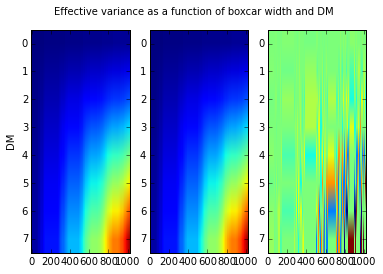

In [3]:
fig,axs = subplots(1,3)
fig.suptitle('Effective variance as a function of boxcar width and DM')
axs[0].imshow(eff_sigma**2, aspect='auto')
axs[0].set_ylabel('boxcar')
axs[0].set_ylabel('DM')
axs[1].imshow(eff_var, aspect='auto')
axs[2].imshow(eff_sigma**2 - eff_var, aspect='auto') # essentially zero
print 'Both methods the same?', np.all((eff_sigma**2 - eff_var) < 1e-3)


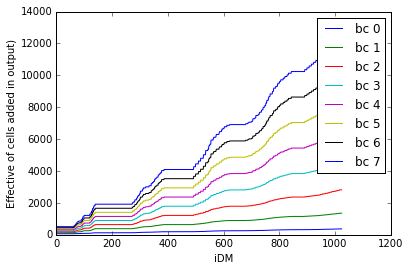

In [4]:
# The number of hits is really the variance - sorry about the 
lables = ['bc %d'%b for b in xrange(nbox)]
nhits = eff_var
plot(nhits.T)
legend(lables)
xlabel('iDM')
ylabel('Effective of cells added in output)')


(0, 2048)

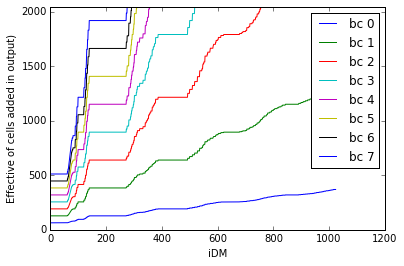

In [5]:
# zoom in a bit
plot(nhits.T)
legend(lables)
xlabel('iDM')
ylabel('Effective of cells added in output)')
ylim(0, 2048)


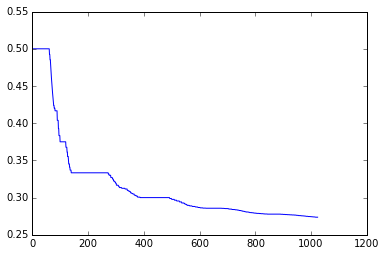

In [6]:
# They aren't simple scalings of each other
plot((nhits[0,:]/nhits[1,:]).T)

So this makes sense. Less than the diagonal DM, the number of hits is equals the number of channels times the width of the boxcar


In [7]:
# So for fun, let's run ones through the FDMT

fdmtin = np.ones((nf, nt))
fdmtout = thefdmt(fdmtin)

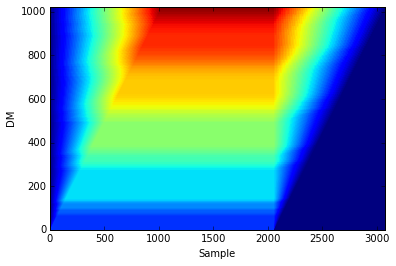

In [8]:
imshow(fdmtout, aspect='auto', origin='lower')
xlabel('Sample')
ylabel('DM')

In [9]:
# OK FDMT of ones with all the history for ever happens at sample nd+1
nhits_ones = fdmtout[:, nd+1]

are they equal? True


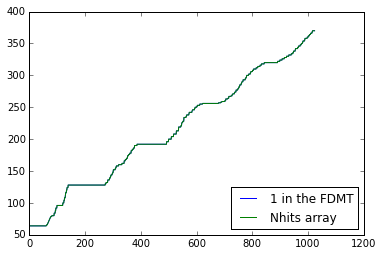

In [10]:
plot(nhits_ones, label='1 in the FDMT')
plot(nhits[0,:], label='Nhits array')
legend(loc='lower right')
print "are they equal?", np.all(nhits_ones == nhits[0,:])

So I think the effective variance calculation is OK - I guess we haven't addded the boxcar stuff yet, but Harry could try that.

# But I've noticed the FDMT and my FRB sim code make FRBs that look different. E.g.

I assumed this was a problem with a naive FRB simulation, but perhaps that's not true?


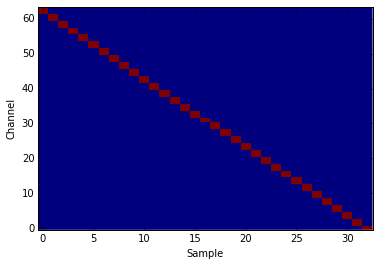

In [11]:
# Ask the FDMT which cells it would add together if it dedpersed at a DM of IDT
idt =32
# add_frb_track() puts a 1 where it would add that cell when calculating the given DM
frb_fdmt = thefdmt.add_frb_track(idt) 
imshow(frb_fdmt, aspect='auto', origin='lower', interpolation='none')
xlabel('Sample')
ylabel('Channel')

IDT= 32  samples DM = 171.040222312 pc/cm3


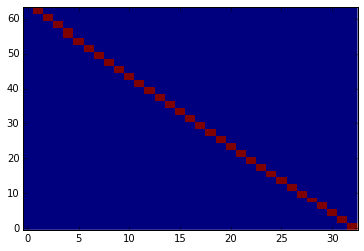

In [12]:
# Simple simulation of an FRB.
# Delay across the band is id*tsamp milliseconds
# tau = 4.15*dm*(nu1**-2-nu2**-2)
# dm = tau/4.15/(nu1**-2 - nu2**-2)

# Express DM in pc/cm3 - it actually divides away later one and you just get the ratio of the squared 
# differences, but just to indulge you
# Possible bug here: How have I defined fmin/fmax - center of chanel? Bottom of channel?
delay_total = idt*tsamp
dm = delay_total/4.15/(fmin**-2 - fmax**-2)
print 'IDT=', idt, ' samples DM =', dm, 'pc/cm3'

simplefrb = np.zeros((nf, idt+1))
offset = 0.25
delays_simple = []
for c in xrange(nf):
    freq = (fmin + c*df)
    delay_ms = -4.15*dm*(fmax**-2 - freq**-2)
    delay_samp = int(np.round(delay_ms/tsamp + offset))
    delays_simple.append(delay_samp)
    simplefrb[c, delay_samp] = 1
    
imshow(simplefrb, aspect='auto', origin='lower', interpolation='none')
    

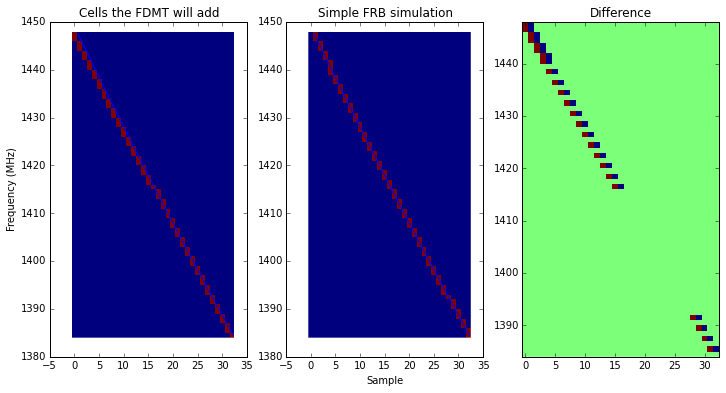

In [13]:
freqs = (np.arange(nf)*df + fmin)
delays_samps = idt*(fmax**-2 - freqs**-2) / (fmax**-2 - fmin**-2) + offset
extents = (-0.5, idt+0.5, (freqs.min()-df/2.)*1e3 ,(freqs.max()+df/2.)*1e3)

fig, axs = subplots(1,3)
fig.set_size_inches([12,6])
axs[0].imshow(frb_fdmt, aspect='auto', origin='lower', interpolation='none', extent=extents)
axs[0].plot(delays_samps, freqs*1e3)

axs[0].set_title('Cells the FDMT will add')
axs[1].imshow(simplefrb, aspect='auto', origin='lower', interpolation='none', extent=extents)
axs[1].plot(delays_samps, freqs*1e3)

axs[1].set_title('Simple FRB simulation')
axs[2].imshow(frb_fdmt - simplefrb, aspect='auto', origin='lower', interpolation='none', extent=extents)
axs[2].set_title('Difference')
axs[0].set_ylabel('Frequency (MHz)')
axs[1].set_xlabel('Sample')

In [14]:
expected = np.sum(simplefrb)
actual = np.sum(simplefrb*frb_fdmt)
recovery = float(actual)/float(expected)
print 'Recovered', recovery*100, '% of the signal'

Recovered 62.5 % of the signal


This loss could be a number of things:
- The way the FDMT and the simple simulation handle channels is differnet (e.g. off by 1, off by 0.5 or shifted by 1, shifted by 1.5, etc). Do we assume the FRB starts at the top of the top channel, and finishes at the bottom of the bottom channel? Or the beginning of the top channel? and ends .. whereever?
- Bug in the FDMT


# Another way of looking at this is looking at the size of the sample delay appllied to each channel


In [15]:
nodes = thefdmt.trace_dm(idt) # Find the delays the FDMT will apply to each channel
# Nodes is a list of tuples containing (channel number, number of tiem samples - 1 added together, delay in samples)
fdmt_channels = [node[0] for node in nodes]
fdmt_widths = np.array([node[1] for node in nodes])

# node[2] contains the delay the FDMT will apply to the channel to dedisperse
# to plot it correctly, we subtract from IDT, to give the delay the FRB has.
fdmt_delays = idt - np.array([node[2] for node in nodes])

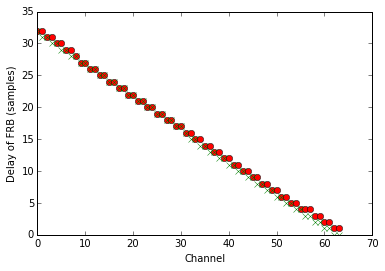

In [16]:
plot(delays_simple, 'ro', label='Simple FRB channel delays')
plot(fdmt_delays, 'gx', label='FDMT channel delays')

xlabel('Channel')
ylabel('Delay of FRB (samples)')

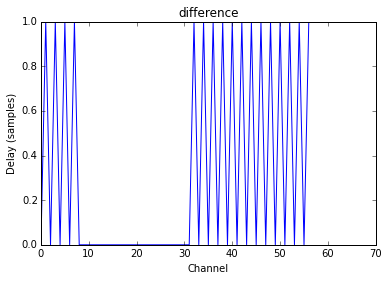

In [17]:
plot(delays_simple - fdmt_delays)
title('difference')

xlabel('Channel')
ylabel('Delay (samples)')


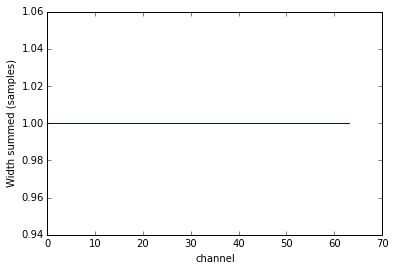

In [18]:
# plot widths, for the record - only interesting for IDT beyond diagonal
plot(fdmt_widths+1)
xlabel('channel')
ylabel('Width summed (samples)')

# How to make a dedispsersed waterfall plot

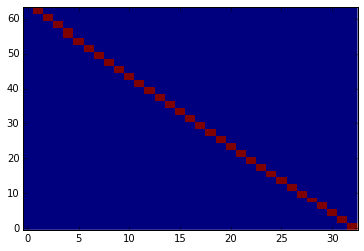

In [23]:
imshow(simplefrb, aspect='auto', origin='lower', interpolation='none')

In [28]:
def dedisperse(frb, thefdmt, idt):
    '''
    Produces a new waterfall plot with the frequency channels delayed accoruding to the delays applied
    by the FDMT
    '''
    nodes = thefdmt.trace_dm(idt) # Find the delays the FDMT will apply to each channel
    dd = np.zeros_like(frb)
    print(dd.shape)
    for channel, width, delay in nodes:
        dd[channel,:] = np.roll(frb[channel,:], delay)
    
    return dd
    

(64, 33)


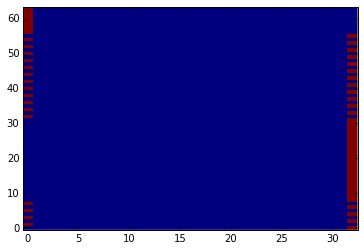

In [30]:
imshow(dedisperse(simplefrb, thefdmt, idt), aspect='auto', origin='lower', interpolation='none')